## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [45]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


# EDA

In [2]:
# check missing values and data types
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
ID           84534 non-null int64
Promotion    84534 non-null object
purchase     84534 non-null int64
V1           84534 non-null int64
V2           84534 non-null float64
V3           84534 non-null float64
V4           84534 non-null int64
V5           84534 non-null int64
V6           84534 non-null int64
V7           84534 non-null int64
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [3]:
# check statistics of training data
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [40]:
# subset data into groups with promotion and not
promotion_yes = train_data.query('Promotion == "Yes"')
promotion_no = train_data.query('Promotion == "No"')

# check promotion "yes" and "no" proportion
total_train = train_data.shape[0]

total_pro = promotion_yes.shape[0]
total_no_pro = promotion_no.shape[0]

print("The number who received the promotion: {} and the number who did not: {}.".format(total_pro, total_no_pro))

pro_no_promo = total_no_pro/total_train
pro_yes_promo = total_pro/total_train

print("proportion of NO promotion = ", pro_no_promo)
print("proportion of promotion = ", pro_yes_promo)

The number who received the promotion: 42364 and the number who did not: 42170.
proportion of NO promotion =  0.4988525327087326
proportion of promotion =  0.5011474672912675


In [24]:
# subset promoted into purchased and not purchased
purchased_yes = promotion_yes.query('purchase == 1')
purchased_no = promotion_yes.query('purchase == 0')

purchase_yes = promotion_no.query('purchase == 1')
purchase_no = promotion_no.query('purchase == 0')

print("#### Promoted ####")

purchase_pro = purchased_yes.shape[0]
print("Number of purchased: ", purchase_pro)
print("purchase ratio of promoted = ",purchased_yes.shape[0]/total_pro)
      
not_purchase_pro = purchased_no.shape[0]
print("Number of not purchased: ", not_purchase_pro)
print("not purchased ratio of promoted = ", not_purchase_pro/total_pro)

print("\n#### Not Promoted ####")
      
purchase_no_pro = purchase_yes.shape[0]
print("Number of purchased: ", purchase_no_pro)
print("purchased ratio of not promoted = ", purchase_yes.shape[0]/total_no_pro)
      
not_purchase_no_pro = purchase_no.shape[0]
print("Number of not purchased: ", not_purchase_no_pro)
print("not purchased ratio of not promoted = ",purchase_no.shape[0]/total_no_pro)

#### Promoted ####
Number of purchased:  721
purchase ratio of promoted =  0.017019167217448776
Number of not purchased:  41643
not purchased ratio of promoted =  0.9829808327825512

#### Not Promoted ####
Number of purchased:  319
purchased ratio of not promoted =  0.007564619397676073
Number of not purchased:  41851
not purchased ratio of not promoted =  0.992435380602324


# Incremental Response Rate (IRR)

In [20]:
irr = purchase_pro/total_pro - purchase_no_pro/total_no_pro
print(IRR)

0.009454547819772702


# Net Incremental Revenue (NIR)

In [26]:
nir = (10*purchase_pro - 0.15*total_pro) - 10*purchase_no_pro
print(NIR)

-2334.5999999999995


# Invariant Metric

The first step will be to analyze our invariant metric of number of participants in our control and experiment (i.e those who recieved a promotional offer vs those who did not).

$$H_{0}: Exp_{participants} - Control_{participants} = 0$$
$$H_{1}: Exp_{participants} - Control_{participants} > 0$$
$$\alpha = 0.05$$

In [43]:
# Calculating a measurable statistic in the difference of our group sizes
sample_difference = pro_yes_promo - pro_no_promo
sample_difference

0.00229493458253488

In [44]:
# Bootstraping our differences to get a model of the distribution for our null
differences = []
for _ in range(10000):
    bootsamp = train_data.sample(30000, replace=True)
    pro_yes_promo_sample = ((bootsamp.Promotion == "Yes").sum())/bootsamp.shape[0]
    pro_no_promo_sample = (bootsamp.Promotion == "No").sum()/bootsamp.shape[0]
    differences.append(pro_yes_promo_sample - pro_no_promo_sample)

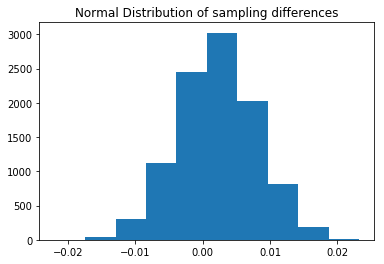

In [46]:
# Visualistion of our distribution 
plt.hist(differences)
plt.title('Normal Distribution of sampling differences');

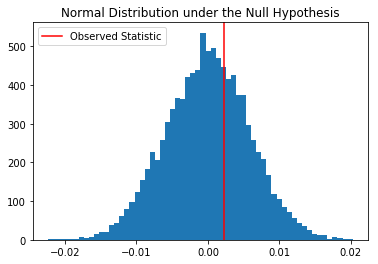

In [47]:
# distribution of our null hypothesis
null_vals = np.random.normal(0, np.std(differences), 10000)
plt.hist(null_vals, bins=60)
plt.axvline(sample_difference, color='r', label ="Observed Statistic")
plt.legend(loc='upper left')
plt.title("Normal Distribution under the Null Hypothesis");

In [48]:
# Determining the signifigance of our result 
p_val = (sample_difference > null_vals).mean()
p_val

0.65290000000000004

#### Conclusion

Our P value is well within our confidence interval and therefore we fail to reject the null hypothesis. This implies that there is no statistical signifigance in the difference of our sampling populations.

In [49]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    
    
    
    return promotion

In [50]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

NameError: name 'promotion' is not defined